# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report

import pickle
from tensorflow.keras.models import load_model

# Load the data and pre-trained models

In [2]:
# Load the the data from the csv file
df = pd.read_csv('../Processed_data/Thyroid_Diff.csv')
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


In [3]:
corr_matrix = df.corr().round(2)
features = corr_matrix['Recurred'].sort_values(ascending=False)
selected_features = features[(features > 0.3) | (features < -0.3)]
selected_features_names = selected_features.index
selected_features_names = selected_features_names.drop('Recurred')


# Split the data into features and target
X = df[selected_features_names]
y = df['Recurred']

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# ANN model saved as h5 file
ANN = load_model('saved_models/ANN_model.h5')

# SVM, KNN, RF models saved as pickle files
with open('saved_models/SVM_model.pkl', 'rb') as file:
    SVM = pickle.load(file)

with open('saved_models/KNN_model.pkl', 'rb') as file:
    KNN = pickle.load(file)

with open('saved_models/RF_model.pkl', 'rb') as file:
    RF = pickle.load(file)

with open('saved_models/DT_model.pkl', 'rb') as file:
    DT = pickle.load(file)

c:\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code 

# Ensemble models

## pre-trained models modifications

In [5]:
# Create a function to use the ANN model in the ensemble
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

# Wrapping ANN model for sklearn compatibility
ANN_wrapper = KerasClassifier(model=ANN, epochs=10, batch_size=32, verbose=0)


## Voting Classifier

In [6]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('svm', SVM), 
        ('knn', KNN), 
        ('rf', RF), 
        ('dt', DT),
        ('ann', ANN_wrapper)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
print("Voting Classifier")
print(f"accuracy_score: {accuracy_score(y_test, y_pred_voting)}")
print(f"AUC: {roc_auc_score(y_test, y_pred_voting)}")
print(classification_report(y_test, y_pred_voting))


Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Voting Classifier
accuracy_score: 0.9727272727272728
AUC: 0.9667397660818713
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.97      0.95      0.96        38

    accuracy                           0.97       110
   macro avg       0.97      0.97      0.97       110
weighted avg       0.97      0.97      0.97       110



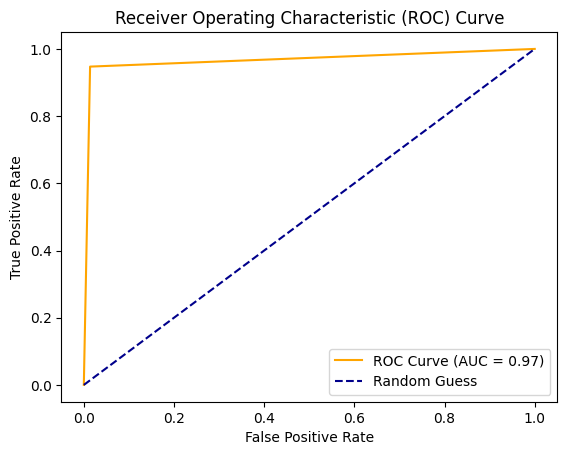

In [7]:
# plot the AUC-ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_voting)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()


## Stacking Classifier

In [8]:
# Stacking Classifier
estimators = [
    ('svm', SVM), 
    ('knn', KNN), 
    ('rf', RF), 
    ('dt', DT),
    ('ann', ANN_wrapper)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
print("Stacking Classifier")
print(f"accuracy_score: {accuracy_score(y_test, y_pred_stacking)}")
print(f"AUC: {roc_auc_score(y_test, y_pred_stacking)}")
print(classification_report(y_test, y_pred_stacking))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Stacking Classifier
accuracy_score: 0.9636363636363636
AUC: 0.9597953216374269
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        72
           1       0.95      0.95      0.95        38

    accuracy                           0.96       110
   macro avg       0.96      0.96      0.96       110
weighted avg       0.96      0.96      0.96       110



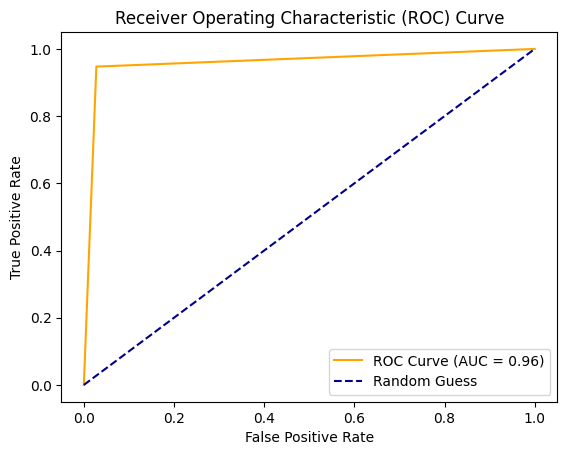

In [9]:
# plot the AUC-ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_stacking)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()